# Nested Angular Grid Example
This notebook demonstrates how to create and use a nested angular grid for numerical integration in quantum chemistry calculations.


In [2]:
# Install required packages
!pip install git+https://github.com/theochem/grid.git
!pip install qc-AtomDB

  Cloning https://github.com/theochem/grid.git to /tmp/pip-req-build-0h9qe9yu
  Running command git clone --filter=blob:none --quiet https://github.com/theochem/grid.git /tmp/pip-req-build-0h9qe9yu
  Resolved https://github.com/theochem/grid.git to commit 834ecaa21d49e1ee7fe814a86c9b8aa294bed0cf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Importing Libraries
We import necessary libraries for numerical calculations, grid generation, and molecular modeling:
- NumPy for numerical operations
- grid package for creating and manipulating integration grids
- atomdb for creating molecular models


In [3]:
# Import required libraries
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

## Icosahedron Grid Generation
The following functions create an icosphere grid by starting with a regular icosahedron and subdividing its faces.
This approach provides an evenly distributed set of points on a sphere, which is ideal for angular integration.


In [4]:
# Function to generate the vertices of a regular icosahedron
def icosahedron_vertices():
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2

    # Normalize the length to 1
    a = 1 / np.sqrt(1 + phi ** 2)
    b = phi * a

    # Vertices of an icosahedron
    vertices = [
        (-a, b, 0), (a, b, 0), (-a, -b, 0), (a, -b, 0),
        (0, -a, b), (0, a, b), (0, -a, -b), (0, a, -b),
        (b, 0, -a), (b, 0, a), (-b, 0, -a), (-b, 0, a)
    ]
    return np.array(vertices)

### Subdivision and Icosphere Generation
The following functions refine the icosahedron by subdividing its faces to create a more detailed icosphere.
This process increases the number of points on the sphere, improving the accuracy of our integration.


In [5]:
# Function to subdivide the faces of an icosahedron
def subdivide(vertices, faces):
    # New vertex set, including old vertices
    new_vertices = vertices.tolist()
    vertex_map = {}

    # Helper function to find the midpoint and index
    def midpoint_index(v1, v2):
        # Check if we have already calculated this
        edge = tuple(sorted([v1, v2]))
        if edge in vertex_map:
            return vertex_map[edge]

        # Calculate midpoint and normalize it to the sphere
        midpoint = (vertices[v1] + vertices[v2]) / 2
        midpoint /= np.linalg.norm(midpoint)

        # Store the new vertex index
        index = len(new_vertices)
        new_vertices.append(midpoint)
        vertex_map[edge] = index
        return index

    new_faces = []

    for v1, v2, v3 in faces:
        # Get the midpoints
        a = midpoint_index(v1, v2)
        b = midpoint_index(v2, v3)
        c = midpoint_index(v3, v1)

        # Create four new faces
        new_faces.extend([
            [v1, a, c],
            [v2, b, a],
            [v3, c, b],
            [a, b, c]
        ])

    return np.array(new_vertices), np.array(new_faces)


# Function to generate an icosphere with a specified number of subdivisions
def generate_icosphere(subdivisions):
    # Initial icosahedron vertices and faces
    vertices = icosahedron_vertices()
    faces = [
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7, 10], [0, 10, 11],
        [1, 5, 9], [5, 11, 4], [11, 10, 2], [10, 7, 6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4, 11], [6, 2, 10], [8, 6, 7], [9, 8, 1]
    ]

    # Subdivide the triangles the number of times specified
    for _ in range(subdivisions):
        vertices, faces = subdivide(vertices, faces)

    return vertices

### Weight Calculation and Angular Grid Generation
These functions calculate the integration weights for our grid points and generate the angular grid.
The weights ensure that our numerical integration is accurate, and the caching mechanism (@lru_cache) 
improves performance by storing previously calculated grids.


In [6]:
# Function to calculate integration weights for grid points
def calculate_weights(points):
    # Convert Cartesian coordinates to spherical coordinates
    points_sph = convert_cart_to_sph(points)
    r, theta, phi = points_sph.T
    n_points = len(points)
    l_max = (np.sqrt(n_points) - 1).astype(int)

    # Generate spherical harmonics for the points
    spherical_harmonics = generate_real_spherical_harmonics(l_max, theta, phi)
    n_spherical_harmonics = len(spherical_harmonics)

    # Set up the right-hand side of the equation
    b = np.zeros(n_spherical_harmonics)
    b[0] = np.sqrt(4 * np.pi)

    # Solve the least squares problem to find the weights
    w_sphere, _, _, s = np.linalg.lstsq(spherical_harmonics.astype(np.float64), b)

    return w_sphere


# Function to generate an angular grid from an icosphere with caching for efficiency
@lru_cache(maxsize=None)
def angular_grid_from_icosphere(icosphere_order):
    points = generate_icosphere(icosphere_order)
    w_sphere = calculate_weights(points)
    return points, w_sphere

## Molecule Setup and Radial Grid Generation
Here we define a simple atom (neon) at the origin and create a radial grid for integration.
The radial grid is combined with the angular grid to form a complete 3D integration grid.


In [7]:
# Define atom/molecule (neon atom at the origin)
atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

# Generate radial grid with 400 points from 0 to 10 Bohr
oned_grid = Trapezoidal(npoints=400)
radial_grid = LinearFiniteRTransform(0.0, 10).transform_1d_grid(oned_grid)

## Density Functional Theory (DFT) - PBE exchange functional
These functions implement various functions needed for PBE exchange calculations:
- Fermi wave vector (k_f)
- Exchange energy density (eps_x)
- Dimensionless density gradient (s)
- Enhancement factor (f_x) for PBE exchange functional
- Exchange energy (e_x)
- Exchange potential (v_x)


In [8]:
# Functions for DFT calculations

# Calculate Fermi wave vector
def k_f(dens_point):
    kf = (dens_point * 3 * np.pi ** 2) ** (1 / 3)
    return kf


# Calculate exchange energy density
def eps_x(dens_point):
    e_val = 1
    kf = k_f(dens_point)
    epsx = -3 * kf * e_val ** 2 / (4 * np.pi)
    return epsx


# Calculate dimensionless density gradient
def dimless_dens_grad(dens_point, grad_point):
    kf = k_f(dens_point)
    s = grad_point / (2 * kf * dens_point)
    return s


# Calculate enhancement factor for PBE exchange functional
def f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    fx = 1 + kappa - kappa / (1 + (mu / kappa) * s ** 2)
    return fx


# Calculate exchange energy
def e_x(dens_point, grad_point):
    epsx = eps_x(dens_point)
    fx = f_x(dens_point, grad_point)
    ex = epsx * fx * dens_point
    return ex


# Helper function to normalize vectors
def unit_v(vector):
    return vector / np.linalg.norm(vector, axis=1, keepdims=True)


# Calculate density gradient gradient
def dens_grad_grad(grid):
    dd_dens_norm = promol.atoms[0].dd_dens_func()(np.linalg.norm(grid, axis=1))
    return dd_dens_norm[:, None] * unit_v(grid)


# Helper function for exchange potential calculation
def alg(grad_vec, dens_grad_grad):
    a = grad_vec * dens_grad_grad
    return a.sum(axis=1)


# Calculate derivative of enhancement factor
def d_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    dfx = 2 * kappa ** 2 * mu * s / (kappa + mu * s ** 2) ** 2
    return dfx


# Calculate second derivative of enhancement factor
def dd_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    b = mu * s ** 2 / kappa + 1
    ddfx = -kappa * (8 * mu ** 2 * s ** 2 / (kappa ** 2 * b ** 3) - 2 * mu / (kappa * b ** 2))
    return ddfx


# Calculate exchange potential
def v_x(dens_point, grad_point, lap_point, grad_vec, dens_grad_grad):
    s = dimless_dens_grad(dens_point, grad_point)
    fx = f_x(dens_point, grad_point)
    kf = k_f(dens_point)
    algo = alg(grad_vec, dens_grad_grad)
    dfx = d_f_x(dens_point, grad_point)
    ddfx = dd_f_x(dens_point, grad_point)

    a_x = -3 * (3 * np.pi ** 2) ** (1 / 3) / (4 * np.pi)

    vx = a_x * dens_point ** (1 / 3) * (4 * fx / 3 +
                                        (-4 / 3 * s - (
                                            1 / (2 * kf) * lap_point / grad_point) + 1 / (
                                             2 * kf) * algo / (
                                             grad_point ** 2)) * dfx +
                                        (-1 / (2 * kf) ** 2 * algo / (
                                            grad_point * dens_point) + 4 / 3 * s ** 2) * ddfx)
    return vx

## Variable Calculation Functions
These functions calculate different properties at each grid point:
- Number of electrons (electron density)
- Exchange energy
- Exchange potential

These are the quantities we want to integrate over the grid.


In [9]:
# Functions to calculate different variables at grid points

# Calculate electron density at grid points
def calc_num_e(promol, points):
    return promol.density(points)


# Calculate exchange energy at grid points
def calc_e_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    return e_x(dens, dens_grad_norm)


# Calculate exchange potential at grid points
def calc_v_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    dens_lap = promol.laplacian(points)
    dens_gradgrad = dens_grad_grad(points)
    vx = v_x(dens, dens_grad_norm, dens_lap, dens_grad, dens_gradgrad)
    return vx

## Adaptive Grid Function
This is the main function that creates an adaptive integration grid. It works by:
1. Starting with a coarse grid
2. Comparing with a reference grid to check accuracy
3. For each radial point, increasing the angular resolution until convergence
4. Returning the optimized grid, weights, and icosphere orders

This approach ensures we use just enough grid points to achieve the desired accuracy,
making the calculation more efficient.


In [10]:
# Function to create an adaptive grid for numerical integration
def adaptative_grid(promol, variable, n_rgrid_points=100, tol=None):
    # Select the appropriate calculation function and tolerance based on the variable
    if variable == "num_electrons":
        calc_variable = calc_num_e
        if tol is None:
            tol = 1e-15
    elif variable == "energy":
        calc_variable = calc_e_x
        if tol is None:
            tol = 1e-15
    elif variable == "potential":
        calc_variable = calc_v_x
        if tol is None:
            tol = 1e-5
    else:
        raise ValueError(
            "Variable can only be one of 'num_electrons', 'energy' or 'potential'.")

    print(f'Calculating {variable}...')

    # Generate radial grid
    oned_grid = Trapezoidal(npoints=n_rgrid_points)
    radial_grid = LinearFiniteRTransform(1e-8, 10).transform_1d_grid(oned_grid)

    # Generate initial angular grid and compute the weights
    points_sphere, w_sphere = angular_grid_from_icosphere(0)
    icosphere_orders = np.zeros(len(radial_grid.points), dtype=np.int64)
    grid = np.concatenate([x * points_sphere for x in radial_grid.points])

    # Obtain Becke weights and calculate the total weights
    ws = BeckeWeights().compute_weights(points=grid, atcoords=atcoords, atnums=atnums)
    weights = np.concatenate(
        [w * w_sphere * p ** 2 for w, p in zip(radial_grid.weights, radial_grid.points)])
    mol_weights = weights * ws

    # Calculate the variable at each point and integrate
    val_0_integrand = calc_variable(promol, grid)
    val_0 = np.nansum(val_0_integrand * mol_weights)

    # -------------------------- ITERATIONS AT EACH POINT OF R --------------------
    max_iter = 5

    # Create a reference grid for comparison
    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]
    reference_grid = AtomGrid.from_preset(atnum=atnum,
                                          preset='ultrafine',
                                          rgrid=radial_grid,
                                          center=atcoord)
    val_ref_integrand = calc_variable(promol, reference_grid.points)
    val_ref = np.nansum(val_ref_integrand * reference_grid.weights)
    print(f'{variable} for reference grid = {val_ref:.6f}\n')

    # If initial grid is already accurate enough, return it
    if abs(val_ref - val_0) < tol:
        print(f'{variable} for initial grid = {val_0:.6f}')
        print(f'Difference = {abs(val_ref - val_0):.3e}')
        print("Order 0 grid gives results of similar accuracy to the reference grid.")
        return grid, weights, icosphere_orders

    radial_weights = radial_grid.weights * radial_grid.points ** 2

    # Adaptive refinement for each radial point
    deltae_list = list()
    val_final = 0
    for i, (x, ws) in enumerate(zip(radial_grid.points, radial_weights)):
        # Start with lowest order angular grid
        points_o, weights_o = angular_grid_from_icosphere(0)
        weights = ws * weights_o
        radial_ox = points_o * x
        val_prev_integrand = calc_variable(promol, radial_ox)
        val_prev = np.nansum(val_prev_integrand * weights)

        # Increase angular resolution until convergence
        for order in range(1, max_iter):
            points_o, weights_o = angular_grid_from_icosphere(order)
            weights = ws * weights_o
            radial_ox = points_o * x
            val_test_integrand = calc_variable(promol, radial_ox)
            val_test = np.nansum(val_test_integrand * weights)
            dval = abs(val_test - val_prev)
            if dval < tol:
                # Converged - use previous order
                icosphere_orders[i] = order - 1
                deltae_list.append(dval)
                val_final += val_prev
                break
            else:
                val_prev = val_test
        else:
            # Reached max iterations - use highest order
            icosphere_orders[i] = order
            deltae_list.append(dval)
            val_final += val_test

    # Create final grid and weights using the determined icosphere orders
    grid = np.concatenate([x * angular_grid_from_icosphere(o)[0]
                           for x, o in zip(radial_grid.points, icosphere_orders)])
    weights = np.concatenate([angular_grid_from_icosphere(o)[1] * w
                              for w, o in zip(radial_weights, icosphere_orders)])

    # Print results
    print(f'\n{variable} for final grid = {val_final:.6f}')
    print(f'Difference = {abs(val_final - val_ref):.3e}')

    return grid, weights, icosphere_orders

## Main Execution
In this final section, we:
1. Define our atom (neon) at the origin
2. Create adaptive grids for three different properties:
   - Number of electrons (electron density)
   - Exchange energy
   - Exchange potential

Each grid will be optimized specifically for the property being calculated.


In [11]:
# Define the atom (neon at origin)
atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

### Running the Adaptive Grid Algorithm
Now we run the adaptive grid algorithm for each property. The algorithm will print:
- The reference value calculated on a standard grid
- The final value calculated on our adaptive grid
- The difference between the two values


In [12]:
n_rgrid_points = 250
# Create adaptive grids for different properties
grid_e, weights_e, icosphere_orders_e = adaptative_grid(promol, "num_electrons", n_rgrid_points)
grid_x, weights_x, icosphere_orders_x = adaptative_grid(promol, "energy", n_rgrid_points)
grid_v, weights_v, icosphere_orders_v = adaptative_grid(promol, "potential", n_rgrid_points)

grid_e_16, weights_e_16, icosphere_orders_e_16 = adaptative_grid(promol, "num_electrons", n_rgrid_points, tol=1e-16)
grid_x_16, weights_x_16, icosphere_orders_x_16 = adaptative_grid(promol, "energy", n_rgrid_points, tol=1e-16)

Calculating num_electrons...
num_electrons for reference grid = 9.996794


num_electrons for final grid = 9.996794
Difference = 4.086e-14
Calculating energy...


/tmp/ipykernel_97009/1775444682.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_sphere, _, _, s = np.linalg.lstsq(spherical_harmonics.astype(np.float64), b)
$HOME/miniconda3/lib/python3.11/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
$HOME/miniconda3/lib/python3.11/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)
/tmp/ipykernel_97009/1775444682.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision time

energy for reference grid = -12.040391

energy for final grid = -12.040391
Difference = 4.086e-14
Calculating potential...
potential for reference grid = -33.394777


$HOME/miniconda3/lib/python3.11/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
$HOME/miniconda3/lib/python3.11/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)
/tmp/ipykernel_97009/1775444682.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_sphere, _, _, s = np.linalg.lstsq(spherical_harmonics.astype(np.float64), b)



potential for final grid = -33.456511
Difference = 6.173e-02
Calculating num_electrons...
num_electrons for reference grid = 9.996794


$HOME/miniconda3/lib/python3.11/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
$HOME/miniconda3/lib/python3.11/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)



num_electrons for final grid = 9.996794
Difference = 3.730e-14
Calculating energy...
energy for reference grid = -12.040391


$HOME/miniconda3/lib/python3.11/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
$HOME/miniconda3/lib/python3.11/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)



energy for final grid = -12.040391
Difference = 3.730e-14


# Comparison between grids

Import plotting libraries

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

## Comparison between adaptative grids

First, we compare the icosphere order for every radial point.

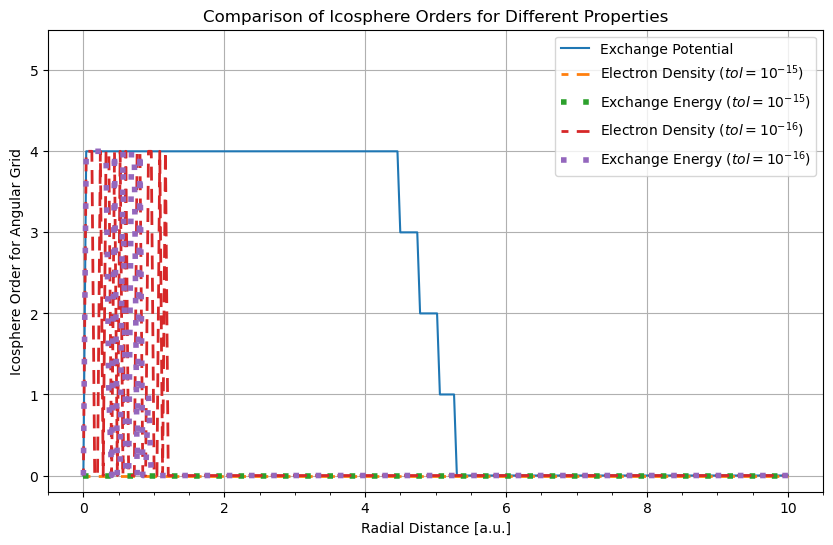

In [14]:
oned_grid = Trapezoidal(npoints=n_rgrid_points)
radial_grid = LinearFiniteRTransform(0.0, 10).transform_1d_grid(oned_grid)
x = radial_grid.points

plt.figure(figsize=(10, 6))
plt.plot(x, icosphere_orders_v, label='Exchange Potential')
plt.plot(x, icosphere_orders_e, label='Electron Density ($tol=10^{-15}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, icosphere_orders_x, label='Exchange Energy ($tol=10^{-15}$)', linestyle=(0, (1, 3)), linewidth=4)
plt.plot(x, icosphere_orders_e_16, label='Electron Density ($tol=10^{-16}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, icosphere_orders_x_16, label='Exchange Energy ($tol=10^{-16}$)', linestyle=(0, (1, 3)), linewidth=4)

ax = plt.gca()
ax.set_ylim([None, 5.5])
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlabel('Radial Distance [a.u.]')
plt.ylabel('Icosphere Order for Angular Grid')
plt.title('Comparison of Icosphere Orders for Different Properties')
plt.legend()
plt.grid()

Then, we compare the number of points in the icosphere corresponding to each radial point.

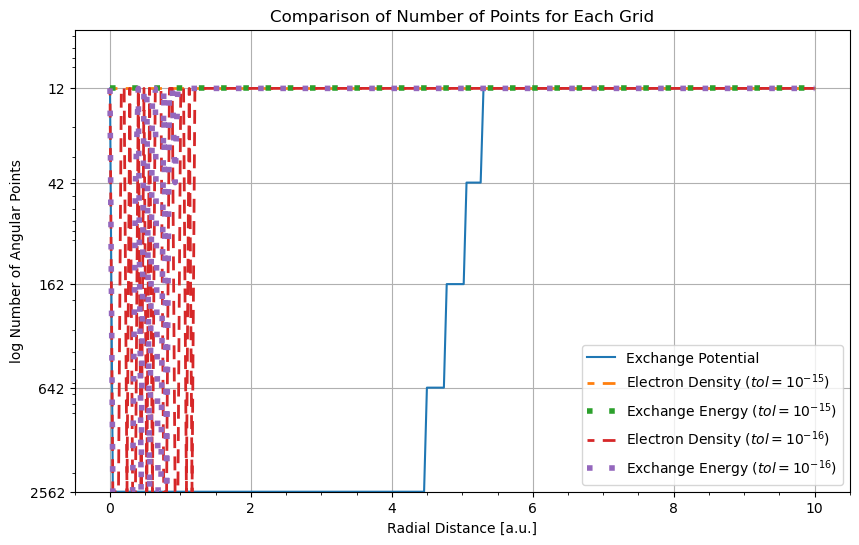

In [15]:
ICOSPHERE_NPOINTS = {
    0: 12,
    1: 42,
    2: 162,
    3: 642,
    4: 2562,
    5: 10242,
    6: 40962,
    7: 163842,
    8: 655362,
    9: 2621442,
    10: 10485762,
}
y_v = [ICOSPHERE_NPOINTS[o] for o in icosphere_orders_v]
y_e = [ICOSPHERE_NPOINTS[o] for o in icosphere_orders_e]
y_x = [ICOSPHERE_NPOINTS[o] for o in icosphere_orders_x]
y_e_16 = [ICOSPHERE_NPOINTS[o] for o in icosphere_orders_e_16]
y_x_16 = [ICOSPHERE_NPOINTS[o] for o in icosphere_orders_x_16]

plt.figure(figsize=(10, 6))
plt.plot(x, y_v, label='Exchange Potential')
plt.plot(x, y_e, label='Electron Density ($tol=10^{-15}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, y_x, label='Exchange Energy ($tol=10^{-15}$)', linestyle=(0, (1, 3)), linewidth=4)
plt.plot(x, y_e_16, label='Electron Density ($tol=10^{-16}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, y_x_16, label='Exchange Energy ($tol=10^{-16}$)', linestyle=(0, (1, 3)), linewidth=4)

plt.yscale('log')
ax = plt.gca()
ax.set_ylim([None, 5.5])
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
max_val = max(max(icosphere_orders_e), max(icosphere_orders_v), max(icosphere_orders_x))
y_ticks = [ICOSPHERE_NPOINTS[i] for i in range(max_val + 1)]
ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_ticks)

plt.xlabel('Radial Distance [a.u.]')
plt.ylabel('log Number of Angular Points')
plt.title('Comparison of Number of Points for Each Grid')
plt.legend()
plt.grid()

## Comparison of adaptative grids with presets included in theochem/grid

In [16]:
presets = ['coarse', 'medium', 'fine', 'veryfine', 'ultrafine', 'insane']
radius_count_list = []
grid_presets = {}

atnum = promol.atoms[0]._data.atnum
atcoord = promol.coords[0]
for preset in presets:
    reference_grid = AtomGrid.from_preset(atnum=atnum,
                                          preset=preset,
                                          rgrid=radial_grid,
                                          center=atcoord)
    grid_presets[preset] = reference_grid
    grid_norm = np.linalg.norm(reference_grid.points, axis=1)
    norm_list = np.round(grid_norm* 10**5)
    radius, counts = np.unique(norm_list, axis=0, return_counts=True)
    radius /= 10**5
    radius_count_list.append((radius, counts))


$HOME/miniconda3/lib/python3.11/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


We compare the distribution of the number of points in the sphere corresponding to each radial point.

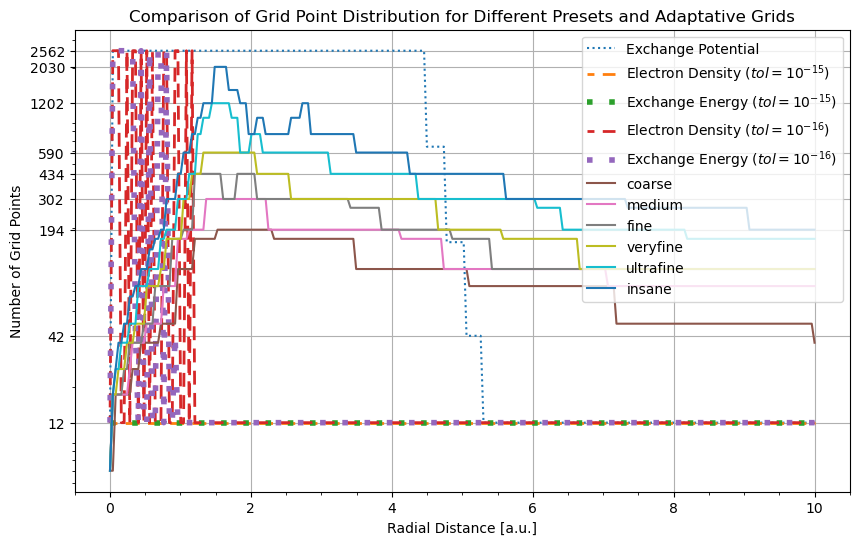

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(x, y_v, label='Exchange Potential', linestyle=':')
plt.plot(x, y_e, label='Electron Density ($tol=10^{-15}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, y_x, label='Exchange Energy ($tol=10^{-15}$)', linestyle=(0, (1, 3)), linewidth=4)
plt.plot(x, y_e_16, label='Electron Density ($tol=10^{-16}$)', linestyle=(2.5, (5, 3)), linewidth=2)
plt.plot(x, y_x_16, label='Exchange Energy ($tol=10^{-16}$)', linestyle=(0, (1, 3)), linewidth=4)

for i, (radius, counts) in enumerate(radius_count_list):
    plt.plot(radius, counts, label=presets[i])

plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

y_ticks = [12, 42] + [max(counts) for radius, counts in radius_count_list] + [2562]
ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_ticks)

plt.xlabel('Radial Distance [a.u.]')
plt.ylabel('Number of Grid Points')
plt.title('Comparison of Grid Point Distribution for Different Presets and Adaptative Grids')
plt.legend()
plt.grid()

Finally, we compare the total number of points in each grid.

Text(0.5, 1.0, 'Comparison of Total Grid Points for Different Grids')

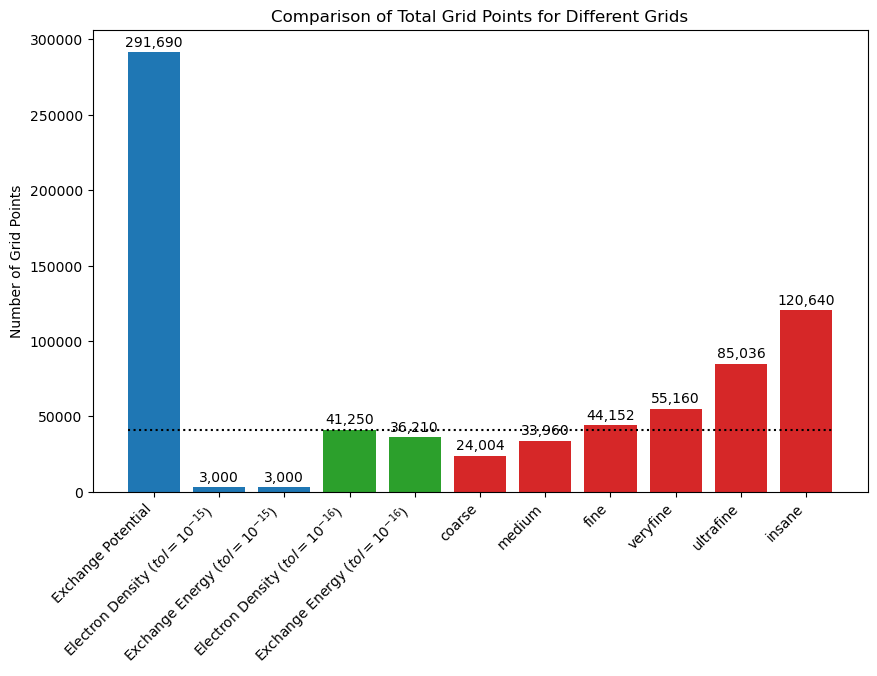

In [18]:
plt.figure(figsize=(10, 6))

grid_name = ['Exchange Potential', 'Electron Density ($tol=10^{-15}$)',
             'Exchange Energy ($tol=10^{-15}$)'] + ['Electron Density ($tol=10^{-16}$)',
                                                    'Exchange Energy ($tol=10^{-16}$)'] + presets

num_points = [sum(y_v), sum(y_e), sum(y_x)] + [sum(y_e_16), sum(y_x_16)]
for radius, counts in radius_count_list:
    num_points.append(sum(counts))

bar_colors = ['tab:blue'] * 3 + ['tab:green'] * 2 + ['tab:red'] * 6

h = plt.bar(grid_name, num_points, color=bar_colors)

plt.plot((-0.4,10.4), (sum(y_e_16), sum(y_e_16)), 'k', linestyle=':')

plt.bar_label(h, padding=2, fmt='{:,.0f}')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Grid Points')
plt.title('Comparison of Total Grid Points for Different Grids')